# Import and Setup


In [30]:
import pandas as pd
from pandas import DataFrame
from ast import literal_eval
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from nltk.tag import pos_tag
import openai
from openai.embeddings_utils import get_embedding
import tiktoken
from sklearn.manifold import TSNE
from ast import literal_eval

In [31]:
import sys

if not sys.warnoptions:
    import warnings

    warnings.simplefilter("ignore", category=UserWarning)
    warnings.simplefilter("ignore", category=RuntimeWarning)

In [32]:
sw = stopwords.words("english")

In [33]:
# embedding model parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191

In [34]:
# read API token from file called .env and call the openai.api_key function

with open("api.txt", "r") as f:
    line = f.readline()

    token = line.split("=")[1].strip()

openai.api_key = token

In [35]:
dataPaths = [
    "input/600_trans.tsv",
    "input/601_trans.tsv",
    "input/603_trans_3.tsv",
    "input/604_trans.tsv",
    "input/614_trans.tsv",
]

data = None

for dataFile in dataPaths:
    data = pd.concat(
        [data, pd.read_csv(dataFile, sep="\t", header=0, encoding="utf-8")],
        ignore_index=True,
    )

In [36]:
data.head(15)

,name,features,transcript,cluster,number,hours,prefix
0,Course Introduction,"In the video, the instructor of the course ENM...","Well, greetings and welcome to the first lectu...",24,1.0,1.0,CEFA
1,Business Ethics,"In this lecture on business ethics, the instru...","Greetings. Hello again. In this lecture, we'll...",25,2.0,1.0,CEFA
2,Introduction to Managerial Finance and Accounting,"In this video, the instructor introduces stude...","Well, hello again and welcome back. In this le...",26,3.0,1.0,CEFA
3,Introduction to Accounting,"In this video, students will learn about the i...","Greetings. In this lecture, we're going to cov...",26,3.1,1.0,CEFA
4,Financial Statements - Income statements and r...,"In this video, the instructor introduces the i...",Greetings. In this lecture. We're going to beg...,26,3.2,1.0,CEFA
5,Financial Statements - Balance sheet,In the video transcript for the course ENMA 60...,Greetings In this lecture. We're going to cont...,26,3.3,1.0,CEFA
6,Financial Statements - Cash Flow,"In this video transcript, the instructor empha...","Hello again. In this lecture, we're going to c...",26,3.4,1.0,CEFA
7,Analyzing Financial Statements and Financial P...,The video introduces the concept of ratio anal...,Greetings Over the last several lectures we've...,26,3.5,1.0,CEFA
8,Analyzing Cash Flow,The key takeaway from this video is that analy...,Greetings. As we discussed in an earlier lectu...,27,4.0,1.0,CEFA
9,Cash and Profit Planning,"In this video, the instructor focuses on the i...","Hello again. In today's lecture, we're going t...",27,4.1,1.0,CEFA


In [37]:
data.drop(["cluster", "hours"], axis=1, inplace=True)

In [38]:
data["combined"] = (
    "Title: "
    + data.name.str.strip()
    + "; Description: "
    + data.features.str.strip()
    + "; Transcript: "
    + data.transcript.str.strip()
)

df = data.drop(columns=["transcript", "features"])

df.head(20)

,name,number,prefix,combined
0,Course Introduction,1.0,CEFA,Title: Course Introduction; Description: In th...
1,Business Ethics,2.0,CEFA,Title: Business Ethics; Description: In this l...
2,Introduction to Managerial Finance and Accounting,3.0,CEFA,Title: Introduction to Managerial Finance and ...
3,Introduction to Accounting,3.1,CEFA,Title: Introduction to Accounting; Description...
4,Financial Statements - Income statements and r...,3.2,CEFA,Title: Financial Statements - Income statement...
5,Financial Statements - Balance sheet,3.3,CEFA,Title: Financial Statements - Balance sheet; D...
6,Financial Statements - Cash Flow,3.4,CEFA,Title: Financial Statements - Cash Flow; Descr...
7,Analyzing Financial Statements and Financial P...,3.5,CEFA,Title: Analyzing Financial Statements and Fina...
8,Analyzing Cash Flow,4.0,CEFA,Title: Analyzing Cash Flow; Description: The k...
9,Cash and Profit Planning,4.1,CEFA,Title: Cash and Profit Planning; Description: ...


# Embedding


In [39]:
encoding = tiktoken.get_encoding(embedding_encoding)

df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens].tail(1000)
len(df)

104

In [40]:
import os

if os.path.exists("output/gpt_embeddings.csv"):
    df = pd.read_csv("output/gpt_embeddings.csv")
    df["embedding"] = df.embedding.apply(literal_eval).apply(np.array)

else:
    df["embedding"] = df.combined.apply(
        lambda x: get_embedding(x, engine=embedding_model)
    )

df.to_csv("output/gpt_embeddings.csv", index=False)

In [42]:
df.head(15)

,name,number,prefix,combined,n_tokens,embedding
0,Course Introduction,1.0,CEFA,Title: Course Introduction; Description: In th...,6473,"[-0.003956745378673077, -0.017916088923811913,..."
1,Business Ethics,2.0,CEFA,Title: Business Ethics; Description: In this l...,4952,"[-0.0010626170551404357, -0.02680325321853161,..."
2,Introduction to Accounting,3.1,CEFA,Title: Introduction to Accounting; Description...,5117,"[-0.01616630144417286, -0.002147387247532606, ..."
3,Financial Statements - Balance sheet,3.3,CEFA,Title: Financial Statements - Balance sheet; D...,5512,"[-0.024996846914291382, 0.011464428156614304, ..."
4,Financial Statements - Cash Flow,3.4,CEFA,Title: Financial Statements - Cash Flow; Descr...,3734,"[-0.03483816981315613, -0.0025355496909469366,..."
5,Analyzing Cash Flow,4.0,CEFA,Title: Analyzing Cash Flow; Description: The k...,5488,"[-0.030511988326907158, -0.004717483650892973,..."
6,Time Value of Money,4.2,CEFA,Title: Time Value of Money; Description: The k...,7098,"[-0.020003441721200943, -0.013492467813193798,..."
7,Risk and Return,5.0,CEFA,Title: Risk and Return; Description: In this v...,6795,"[-0.0036631159018725157, -0.022628501057624817..."
8,Introduction to Portfolio Risk,5.1,CEFA,Title: Introduction to Portfolio Risk; Descrip...,4945,"[-0.01834234409034252, -0.012866445817053318, ..."
9,Incremental Investment Analysis,6.2,CEFA,Title: Incremental Investment Analysis; Descri...,7039,"[-0.010395434685051441, -0.012535670772194862,..."


In [43]:
matrix = np.vstack(df.embedding.values)
matrix.shape

(104, 1536)

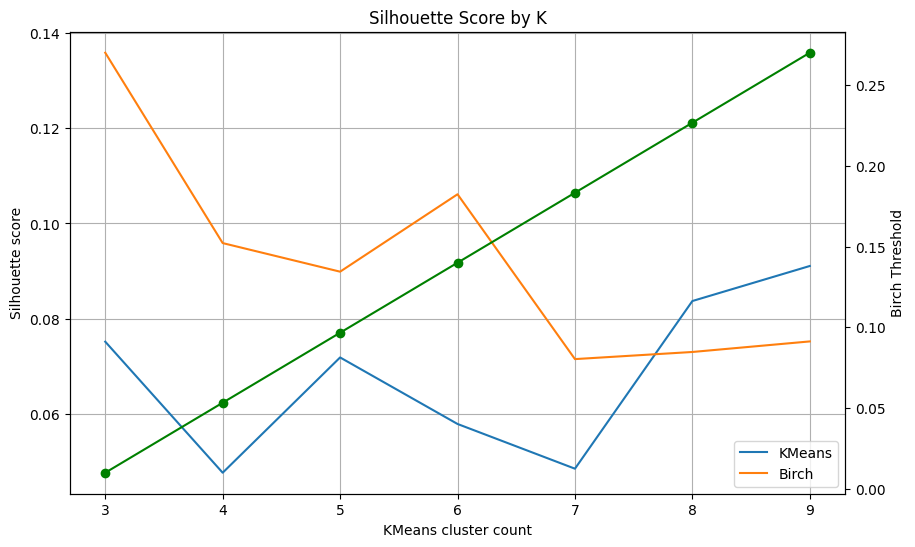

In [44]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, Birch

best_k = 3
max_k = int(np.sqrt(len(df)))

threshold = np.linspace(0.01, 0.4, max_k)

matrix_copy = matrix.copy()

cluster_results_km = pd.DataFrame(
    {
        "K": range(best_k, max_k),
        "K-Silhouette": np.nan,
        "Birch-Silhouette": np.nan,
        "Birch-Threshold": np.nan,
    }
)
cluster_results_km.set_index("K", inplace=True)


for k in range(best_k, max_k):
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42, n_init="auto")
    kmeans.fit(matrix_copy)
    labels_k = kmeans.labels_
    cluster_results_km.loc[k, "K-Silhouette"] = silhouette_score(matrix_copy, labels_k)

    birch = Birch(n_clusters=k, threshold=threshold[k - best_k])
    birch.fit(matrix_copy)
    labels_birch = birch.predict(matrix_copy)
    cluster_results_km.loc[k, "Birch-Silhouette"] = silhouette_score(
        matrix_copy, labels_birch
    )
    cluster_results_km.loc[k, "Birch-Threshold"] = threshold[k - best_k]

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(cluster_results_km.index, cluster_results_km["K-Silhouette"], label="KMeans")
ax1.plot(
    cluster_results_km.index, cluster_results_km["Birch-Silhouette"], label="Birch"
)
ax1.set_ylabel("Silhouette score")
ax1.set_xlabel("KMeans cluster count")
ax1.set_xticks(range(best_k, max_k))


ax2 = ax1.twinx()
ax2.plot(
    cluster_results_km.index,
    cluster_results_km["Birch-Threshold"],
    label="Birch-Threshold",
    color="green",
    marker="o",
)
ax2.set_ylabel("Birch Threshold")
ax1.set_title("Silhouette Score by K")
ax1.grid(True)
ax1.legend(loc="lower right")
plt.show()

best_k = cluster_results_km["K-Silhouette"].idxmax()
best_birch = cluster_results_km["Birch-Silhouette"].idxmax()
best_threshold = cluster_results_km.loc[best_birch, "Birch-Threshold"]

In [45]:
n_clusters = best_k

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42, n_init="auto")
kmeans.fit(matrix_copy)
labels = kmeans.labels_
df["kmeans"] = labels

birch = Birch(n_clusters=best_birch, threshold=best_threshold)
birch.fit(matrix_copy)
labels = birch.predict(matrix_copy)
df["birch"] = labels

In [46]:
kmean_score = silhouette_score(matrix, df.kmeans).round(4)
birch_score = silhouette_score(matrix, df.birch).round(4)

print(f"KMeans silhouette score: {kmean_score}")
print(f"Birch silhouette score: {birch_score}")

KMeans silhouette score: 0.0911
Birch silhouette score: 0.1358


In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
le = LabelEncoder()
tsne = TSNE(n_components=2, random_state=42)

dimensions = pca.fit_transform(matrix)
dimensions_tsne = tsne.fit_transform(matrix)

x = [x for x, y in dimensions]
y = [y for x, y in dimensions]

if n_clusters > 10:
    palette = sns.color_palette("tab20", n_clusters).as_hex()
else:
    palette = sns.color_palette("tab10", n_clusters).as_hex()

df["pca_x"] = [x for x, y in dimensions]
df["pca_y"] = [y for x, y in dimensions]
df["tsne_x"] = [x for x, y in dimensions_tsne]
df["tsne_y"] = [y for x, y in dimensions_tsne]
df["prefix"] = le.fit_transform(df["prefix"].astype(str).str[0])

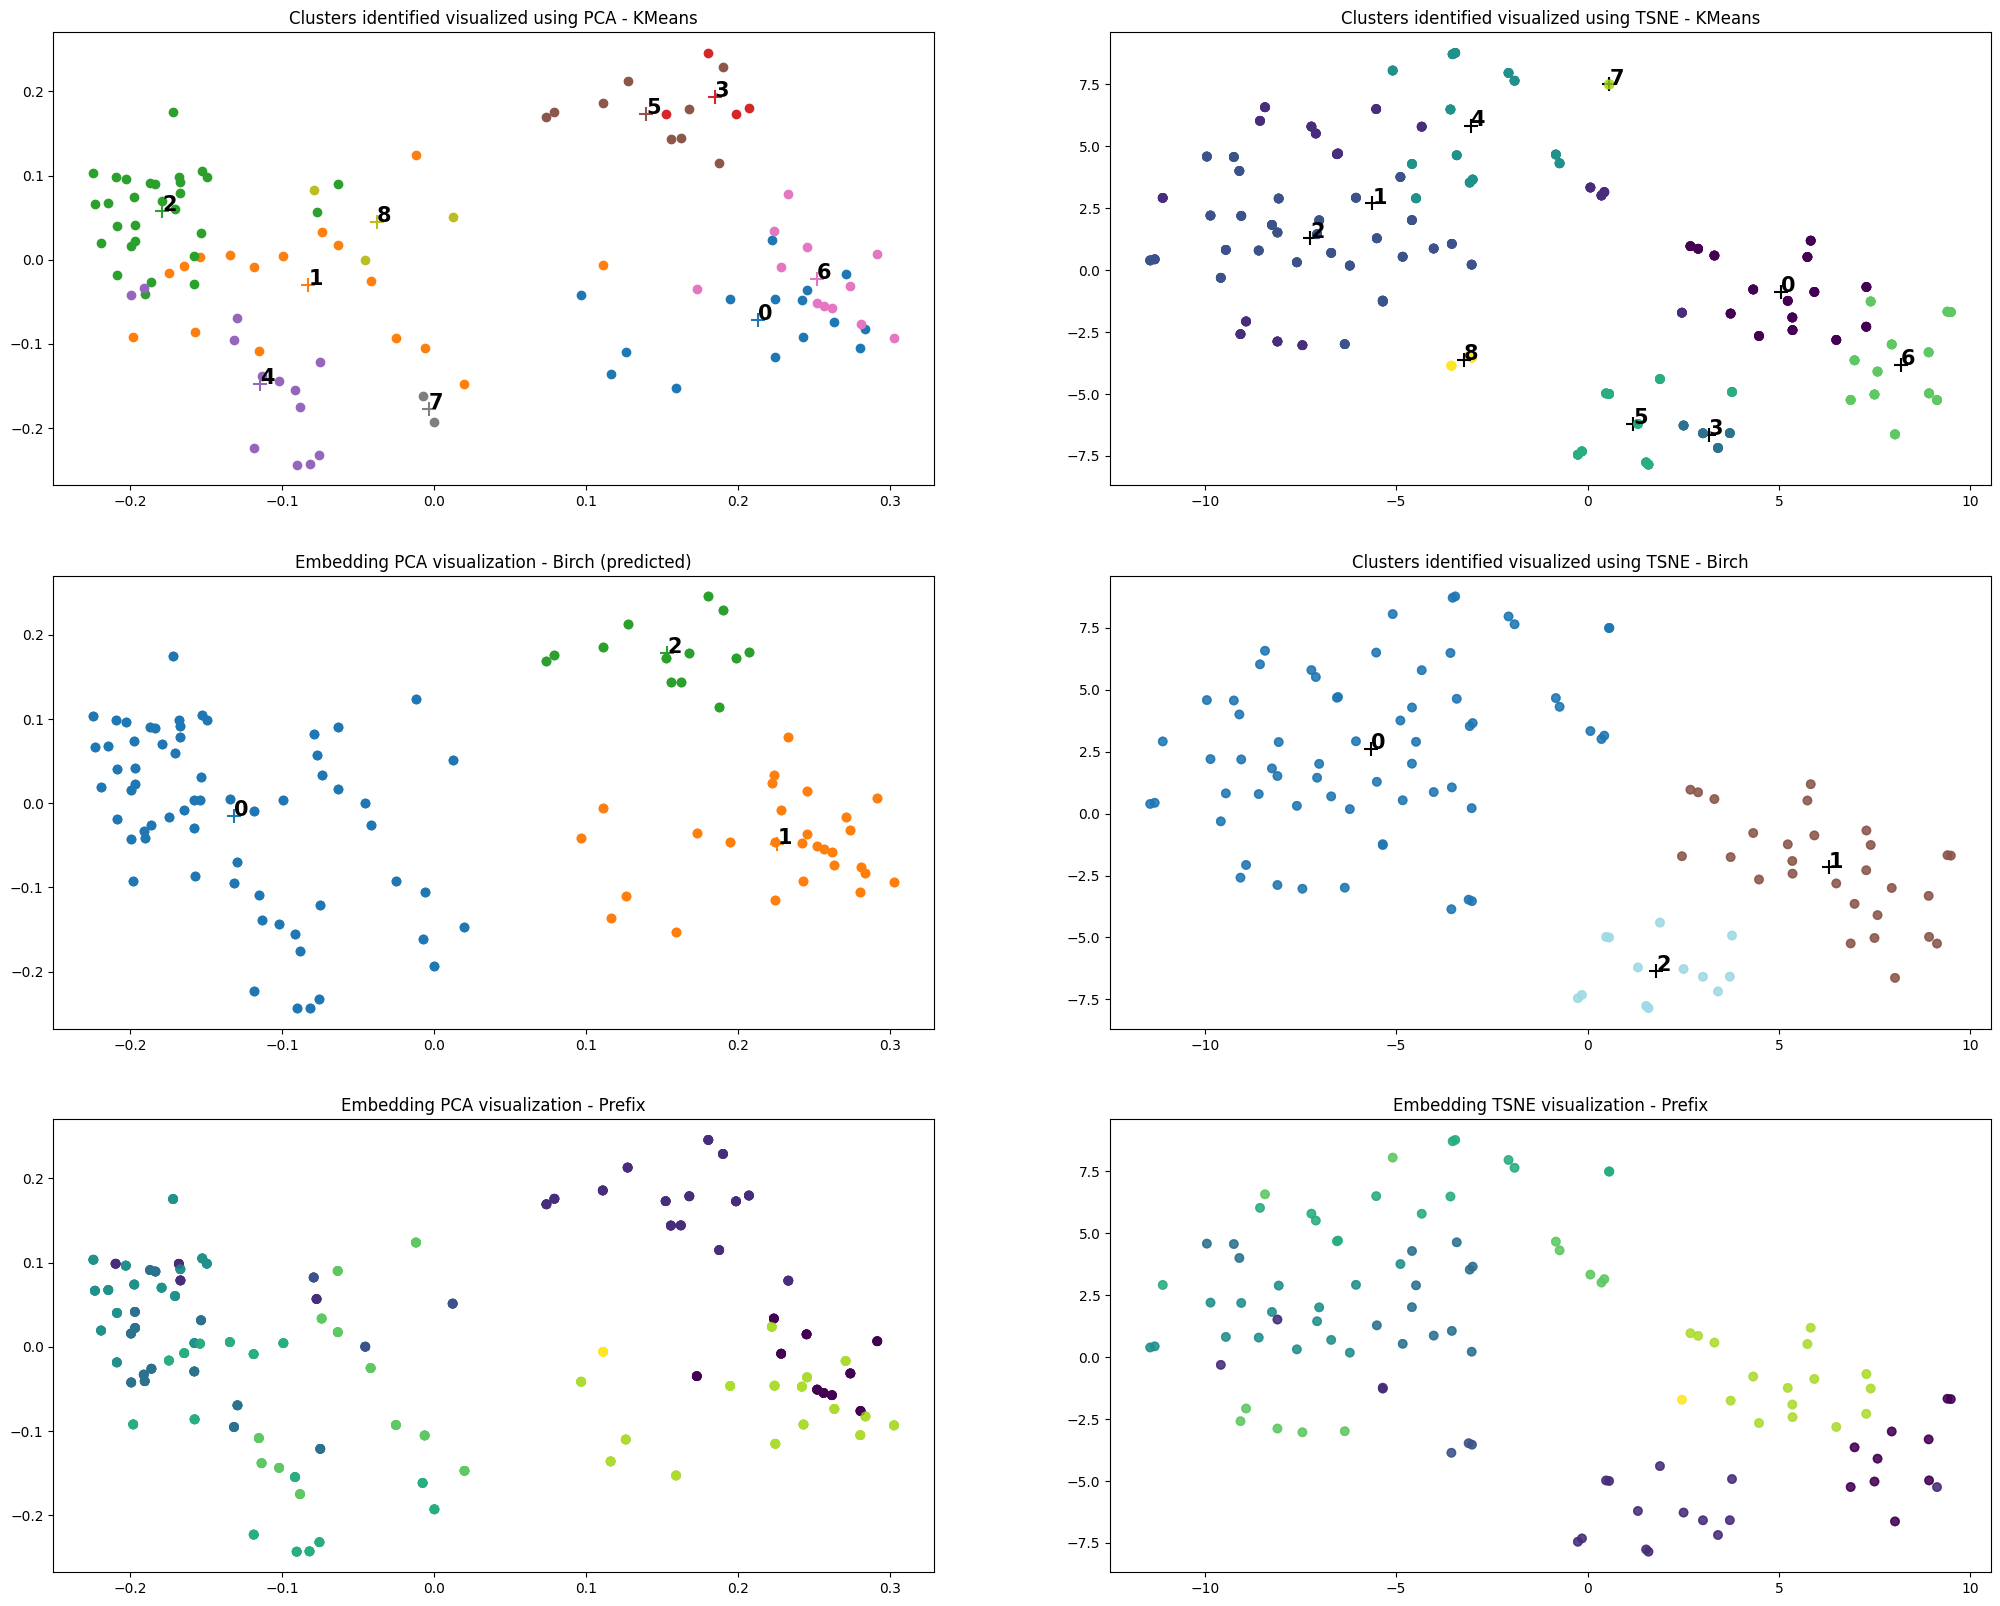

In [48]:
fig, ax = plt.subplots(3, 2, figsize=(25, 20))

for category, color in enumerate(palette):
    xs = np.array(x)[df.kmeans == category]
    ys = np.array(y)[df.kmeans == category]
    avg_x = xs.mean()
    avg_y = ys.mean()

    kmeans_tsne_avg_x = df.tsne_x[df.kmeans == category].mean()
    kmeans_tsne_avg_y = df.tsne_y[df.kmeans == category].mean()

    ax[0][0].scatter(xs, ys, color=color, alpha=1)
    ax[0][0].text(avg_x, avg_y, category, fontsize=15, fontweight="bold")
    ax[0][0].scatter(avg_x, avg_y, marker="+", color=color, s=100)
    ax[0][0].set_title("Clusters identified visualized using PCA - KMeans")

    ax[0][1].scatter(data=df, x="tsne_x", y="tsne_y", c="kmeans", alpha=0.5)
    ax[0][1].scatter(
        kmeans_tsne_avg_x, kmeans_tsne_avg_y, marker="+", color="black", s=100
    )
    ax[0][1].text(
        kmeans_tsne_avg_x, kmeans_tsne_avg_y, category, fontsize=15, fontweight="bold"
    )
    ax[0][1].set_title("Clusters identified visualized using TSNE - KMeans")

    ax[2][0].scatter(data=df, x="pca_x", y="pca_y", c="prefix", alpha=0.5)
    ax[2][0].set_title("Embedding PCA visualization - Prefix")

    if category <= df.birch.max():
        xs2 = np.array(x)[df.birch == category]
        ys2 = np.array(y)[df.birch == category]
        avg_x2 = xs2.mean()
        avg_y2 = ys2.mean()

        birch_tsne_avg_x = df.tsne_x[df.birch == category].mean()
        birch_tsne_avg_y = df.tsne_y[df.birch == category].mean()

        ax[1][0].scatter(xs2, ys2, color=color, alpha=1)
        ax[1][0].text(avg_x2, avg_y2, category, fontsize=15, fontweight="bold")
        ax[1][0].scatter(avg_x2, avg_y2, marker="+", color=color, s=100)
        ax[1][0].set_title("Embedding PCA visualization - Birch (predicted)")
        ax[1][0].scatter(xs2, ys2, color=color, alpha=1)

        ax[1][1].scatter(
            data=df, x="tsne_x", y="tsne_y", c="birch", cmap="tab20", alpha=0.5
        )
        ax[1][1].scatter(
            birch_tsne_avg_x, birch_tsne_avg_y, marker="+", color="black", s=100
        )
        ax[1][1].text(
            birch_tsne_avg_x, birch_tsne_avg_y, category, fontsize=15, fontweight="bold"
        )
        ax[1][1].set_title("Clusters identified visualized using TSNE - Birch")

        ax[2][1].scatter(data=df, x="tsne_x", y="tsne_y", c="prefix", alpha=0.5)
        ax[2][1].set_title("Embedding TSNE visualization - Prefix")

plt.show()

In [49]:
df.head(30)

,name,number,prefix,combined,n_tokens,embedding,kmeans,birch,pca_x,pca_y,tsne_x,tsne_y
0,Course Introduction,1.0,1,Title: Course Introduction; Description: In th...,6473,"[-0.003956745378673077, -0.017916088923811913,...",5,2,0.187500,0.114813,3.774704,-4.920622
1,Business Ethics,2.0,1,Title: Business Ethics; Description: In this l...,4952,"[-0.0010626170551404357, -0.02680325321853161,...",6,1,0.232991,0.078542,9.130939,-5.245906
2,Introduction to Accounting,3.1,1,Title: Introduction to Accounting; Description...,5117,"[-0.01616630144417286, -0.002147387247532606, ...",3,2,0.207090,0.179650,3.717553,-6.582304
3,Financial Statements - Balance sheet,3.3,1,Title: Financial Statements - Balance sheet; D...,5512,"[-0.024996846914291382, 0.011464428156614304, ...",3,2,0.180351,0.245709,3.408512,-7.179611
4,Financial Statements - Cash Flow,3.4,1,Title: Financial Statements - Cash Flow; Descr...,3734,"[-0.03483816981315613, -0.0025355496909469366,...",3,2,0.198571,0.172773,3.015837,-6.586872
5,Analyzing Cash Flow,4.0,1,Title: Analyzing Cash Flow; Description: The k...,5488,"[-0.030511988326907158, -0.004717483650892973,...",3,2,0.152291,0.172943,2.509655,-6.273750
6,Time Value of Money,4.2,1,Title: Time Value of Money; Description: The k...,7098,"[-0.020003441721200943, -0.013492467813193798,...",5,2,0.110902,0.185692,1.316639,-6.210000
7,Risk and Return,5.0,1,Title: Risk and Return; Description: In this v...,6795,"[-0.0036631159018725157, -0.022628501057624817...",5,2,0.167842,0.178799,-0.145483,-7.318326
8,Introduction to Portfolio Risk,5.1,1,Title: Introduction to Portfolio Risk; Descrip...,4945,"[-0.01834234409034252, -0.012866445817053318, ...",5,2,0.162260,0.144203,-0.252599,-7.452457
9,Incremental Investment Analysis,6.2,1,Title: Incremental Investment Analysis; Descri...,7039,"[-0.010395434685051441, -0.012535670772194862,...",5,2,0.079064,0.175822,0.564125,-5.000158
